# PyThia

PyThia performs video prediction for simple physical systems:
given initial video frames, what will a future video frame look like?

## Technical preliminaries

We install the `pythia` package and import it.
We also import other libraries, or tools from other libraries, which will be of use.

In [1]:
pip install git+https://github.com/aremondtiedrez/pythia.git

  Cloning https://github.com/aremondtiedrez/pythia.git to /tmp/pip-req-build-o0e83blr
  Running command git clone --filter=blob:none --quiet https://github.com/aremondtiedrez/pythia.git /tmp/pip-req-build-o0e83blr
  Resolved https://github.com/aremondtiedrez/pythia.git to commit 71e8630e30ddc4be5340849ba002382e0bc4b685
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.5 MB/s eta 0:00:00
  Created wheel for pythia: filename=pythia-0.1.0-py3-none-any.whl size=1687830 sha256=4908679e08e64a3f157a187f6a51d23a9146879a2eeee8d0d905b0e3e0308cf2
  Stored in directory: /tmp/pip-ephem-wheel-cache-e2a_7lso/wheels/73/60/af/5a848e3ca8f5fdcf403911aacc928f3a3fb8578d5add2726bf
Successfully built pythia


In [2]:
from IPython.display import HTML

import pythia

## Getting familiar with the data

The objective of PyThia is, humbly, to predict the future.
That being said, it does so in a very restricted context.

The only data that PyThia models ever see consists in a single ball
bouncing around a box. More precisely, the data consists in snapshots,
evenly spaced in time, of that ball's position.

We must make an important distinction here: PyThia models
are fed *raw image data*. They are not told what the exact position of the ball is, or what its exact velocity is. They are certainly not told anything about the laws of physics or the equations governing elastic collisions between
a ball and a box's walls. These are all things that the models will infer,
to the extend that it helps them fulfill their prediction task.

The task that PyThia models handle is then the following:
given a series of snapshots, can we predict the image that will be captured
a few moments in the future?

In this notebook, there are two easy ways to get your hands on data.
1. Load the demonstration data.
2. Generate (randomly) your own data.

In [6]:
# Load the demonstration data
snapshot_timesteps, positions, velocities, images = pythia.demo.load_data()

# Generate your own data
# (As the number of samples increases, this can become a somewhat lengthy process)
snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10)

Whichever way you got your hands on data, you can take a look at individual samples in the same way.

In [7]:
# Remember: each sample is a sequence of images.
# To see what they look like, in sequence, you can create and
# display a short animation.
sample = images[0]
animation = pythia.visualization.create_animation(sample, display_walls=True)
HTML(animation.to_jshtml())

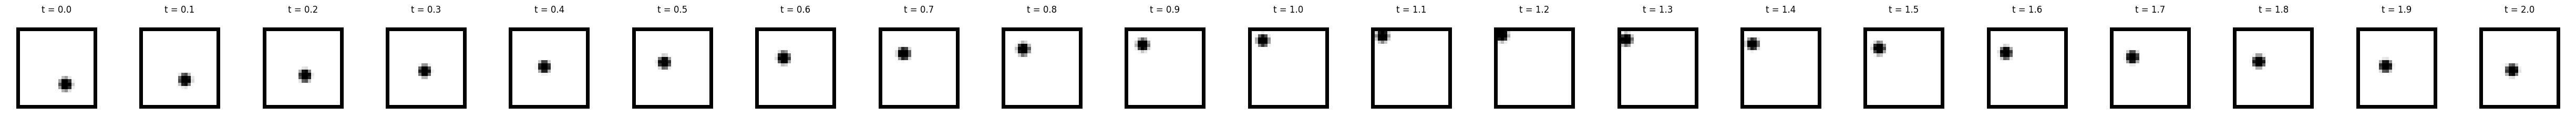

Initial velocity:    [-111.23  141.31]
Position at t = 0.0: [157.71  72.26]
Position at t = 0.1: [146.58  86.39]
Position at t = 0.2: [135.46 100.52]
Position at t = 0.3: [124.23 114.79]
Position at t = 0.4: [113.22 128.78]
Position at t = 0.5: [102.09 142.91]
Position at t = 0.6: [ 90.86 157.18]
Position at t = 0.7: [ 79.85 171.17]
Position at t = 0.8: [ 68.73 185.31]
Position at t = 0.9: [ 57.6  199.44]
Position at t = 1.0: [ 46.48 213.57]
Position at t = 1.1: [ 35.36 227.7 ]
Position at t = 1.2: [ 24.12 230.1 ]
Position at t = 1.3: [ 26.68 216.11]
Position at t = 1.4: [ 37.8  201.98]
Position at t = 1.5: [ 48.93 187.85]
Position at t = 1.6: [ 60.05 173.72]
Position at t = 1.7: [ 71.28 159.45]
Position at t = 1.8: [ 82.29 145.46]
Position at t = 1.9: [ 93.42 131.32]
Position at t = 2.0: [104.54 117.19]


In [8]:
# You can also visualize that same sample by plotting all of its images side-by-side
# (This will also show the initial velocity and the positions of the ball at each time
# when an image has been captured. Remember: the PyThia models never see this information.
# Nonetheless, it can sometimes can in handy to have access to it.)
index = 0
pythia.visualization.inspect_sample(index, snapshot_timesteps, positions, velocities, images, display_walls=True)

## Training the model

Since we are dealing with a computer vision task,
a natural starting point is to use a deep learning approach.

The model architecture we have found to be successful has two components.
- An *encoder*-*decoder* pair consisting of convolutional neural networks
  which map between the raw image data and a learned latent space embedding.
- A *predictor* network which, given a series of past embeddings,
  predicts the embedding of the next image to come.

<img src="https://raw.githubusercontent.com/aremondtiedrez/pythia/main/pythia/demo/architecture.png" width="800">

It turns out that the training process goes more smoothly if the encoder-decoder
pair is pre-trained becfore the full encoder-predictor-decoder architecture is trained.

### Pre-training the encoder-decoder pair

We wish to pre-train the encoder-decoder pair so that the learned embedding
is then useful when predicting the future trajectory from past observations.

To do so, we will train the encoder-decoder pair as part
of a predictive model which, given two images recorded at times $t_1$ and
$t_2$, must predict the image at time $t_3$.
(Where the times are equally spaced, i.e. $t_3 - t_2 = t_2 - t_1$.)

The key is this: the model is constrained to learn a *linear relationship*
between the given embeddings of the first two images and
the prediction of the third image.

The idea is that this constraint forces the model to learn an embedding
which contains rich information for the prediction of future dynamics.

In order to do this, we collect data specifically curated to avoid collisions between the ball and the walls. Once again, that data may be loaded from
the demonstration data or generated here.

In [18]:
# Load the demonstration data
snapshot_timesteps, positions, velocities, images = pythia.demo.load_data(kind="collisionless")

# Generate your own data
# (As the number of samples increases, this can become a somewhat lengthy process)
snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10, max_timestep=0.3, ensure_no_collisions=True)

# These are the parameters that were used to generate the `collisionless` demonstration data:
#snapshot_timesteps, positions, velocities, images = pythia.data_generation.generate(n_samples=10_000, max_timestep=0.3, ensure_no_collisions=True, monitor_progress=True)

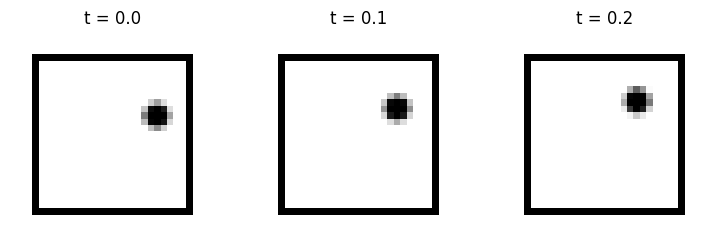

Initial velocity:    [-94.64 117.57]
Position at t = 0.0: [200.94 155.21]
Position at t = 0.1: [191.48 166.97]
Position at t = 0.2: [182.02 178.73]


In [19]:
# This collision-less data can be inspected and animated as before.

# Inspection
index = 0
pythia.visualization.inspect_sample(index, snapshot_timesteps, positions, velocities, images, display_walls=True)

# Animation
sample = images[0]
animation = pythia.visualization.create_animation(sample, display_walls=True)
HTML(animation.to_jshtml())

### Training the full encoder-predictor-decoder architecture